In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [48]:
data = pd.read_csv(r"C:\Users\doris\Downloads\PDDS Major Project Resources-20251020\PDDS Major Project\car_price_dataset.csv")

In [50]:
print("Dataset loaded successfully!")

Dataset loaded successfully!


In [51]:
data.head()

,Unnamed: 0,car_name,brand,model,vehicle_age,km_driven,seller_type,fuel_type,transmission_type,mileage,engine,max_power,seats,selling_price
0,0,Maruti Alto,Maruti,Alto,9,120000,Individual,Petrol,Manual,19.70,796,46.30,5,120000
1,1,Hyundai Grand,Hyundai,Grand,5,20000,Individual,Petrol,Manual,18.90,1197,82.00,5,550000
2,2,Hyundai i20,Hyundai,i20,11,60000,Individual,Petrol,Manual,17.00,1197,80.00,5,215000
3,3,Maruti Alto,Maruti,Alto,9,37000,Individual,Petrol,Manual,20.92,998,67.10,5,226000
4,4,Ford Ecosport,Ford,Ecosport,6,30000,Dealer,Diesel,Manual,22.77,1498,98.59,5,570000


In [52]:
data.tail()

,Unnamed: 0,car_name,brand,model,vehicle_age,km_driven,seller_type,fuel_type,transmission_type,mileage,engine,max_power,seats,selling_price
15406,19537,Hyundai i10,Hyundai,i10,9,10723,Dealer,Petrol,Manual,19.81,1086,68.05,5,250000
15407,19540,Maruti Ertiga,Maruti,Ertiga,2,18000,Dealer,Petrol,Manual,17.50,1373,91.10,7,925000
15408,19541,Skoda Rapid,Skoda,Rapid,6,67000,Dealer,Diesel,Manual,21.14,1498,103.52,5,425000
15409,19542,Mahindra XUV500,Mahindra,XUV500,5,3800000,Dealer,Diesel,Manual,16.00,2179,140.00,7,1225000
15410,19543,Honda City,Honda,City,2,13000,Dealer,Petrol,Automatic,18.00,1497,117.60,5,1200000


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15411 entries, 0 to 15410
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         15411 non-null  int64  
 1   car_name           15411 non-null  object 
 2   brand              15411 non-null  object 
 3   model              15411 non-null  object 
 4   vehicle_age        15411 non-null  int64  
 5   km_driven          15411 non-null  int64  
 6   seller_type        15411 non-null  object 
 7   fuel_type          15411 non-null  object 
 8   transmission_type  15411 non-null  object 
 9   mileage            15411 non-null  float64
 10  engine             15411 non-null  int64  
 11  max_power          15411 non-null  float64
 12  seats              15411 non-null  int64  
 13  selling_price      15411 non-null  int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 1.6+ MB


In [54]:
data.shape

(15411, 14)

In [55]:
data.isna().sum()

Unnamed: 0           0
car_name             0
brand                0
model                0
vehicle_age          0
km_driven            0
seller_type          0
fuel_type            0
transmission_type    0
mileage              0
engine               0
max_power            0
seats                0
selling_price        0
dtype: int64

In [56]:
#data.dropna{inplace=True} for dropping NA values NA values in the dataset

In [57]:
data.duplicated().sum()

np.int64(0)

In [58]:
def remove_outliers_iqr(data, cols):
    dfc = data.copy()
    for col in cols:
        if col not in dfc.columns: continue
        Q1 = dfc[col].quantile(0.25)
        Q3 = dfc[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        dfc = dfc[(dfc[col] >= lower) & (dfc[col] <= upper)]
    return dfc

In [33]:
cols_to_check = ['selling_price', 'km_driven']
df_clean = remove_outliers_iqr(data, cols_to_check)
print("Shape before outlier removal:", data.shape)
print("Shape after outlier removal:", df_clean.shape)

Shape before outlier removal: (15411, 14)
Shape after outlier removal: (13603, 14)


In [34]:
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols)

Numeric columns: ['Unnamed: 0', 'vehicle_age', 'km_driven', 'mileage', 'engine', 'max_power', 'seats', 'selling_price']


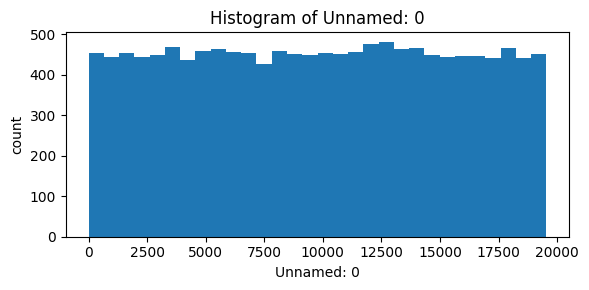

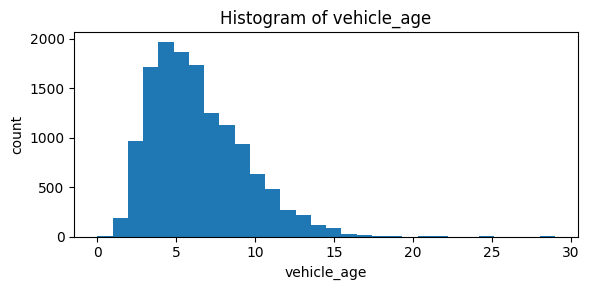

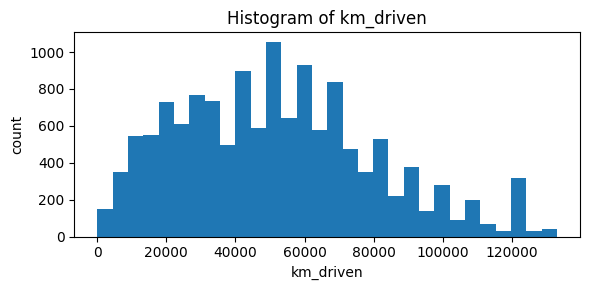

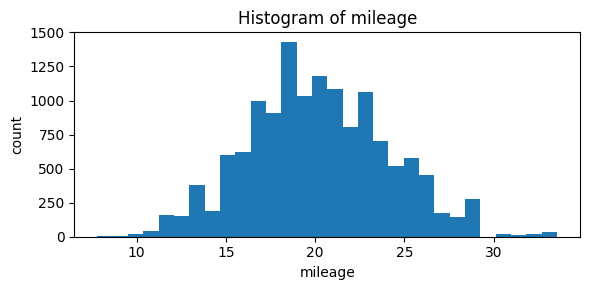

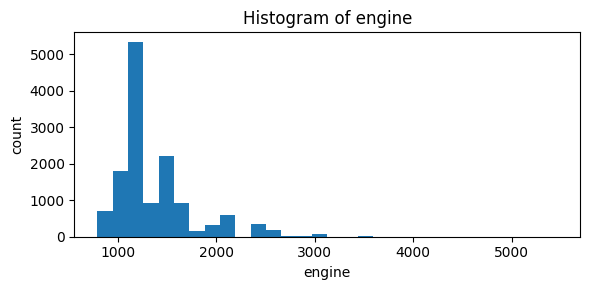

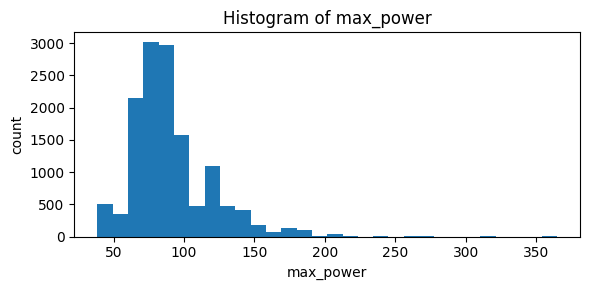

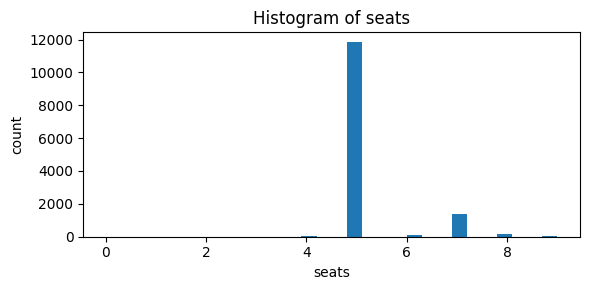

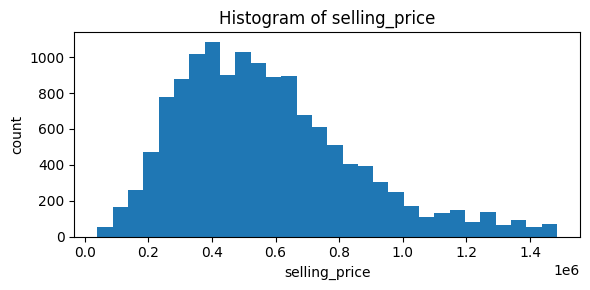

In [59]:
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    plt.hist(df_clean[col].dropna(), bins=30)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

In [36]:
skews = df_clean[numeric_cols].skew().sort_values(ascending=False)
print("\nSkewness:\n", skews)


Skewness:
 seats            2.492497
max_power        1.886348
engine           1.626220
vehicle_age      0.840680
selling_price    0.838872
km_driven        0.464505
mileage          0.159425
Unnamed: 0      -0.004894
dtype: float64


In [37]:
df_model = df_clean.copy()
df_model['log_selling_price'] = np.log1p(df_model['selling_price'])

Categorical cols: ['car_name', 'brand', 'model', 'seller_type', 'fuel_type', 'transmission_type']


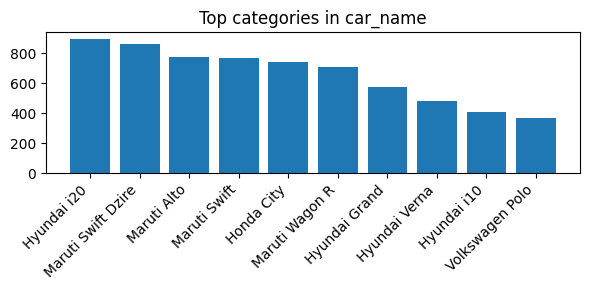

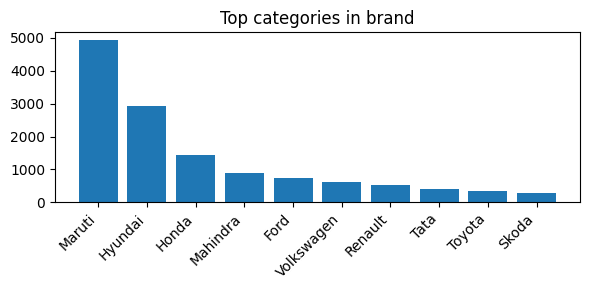

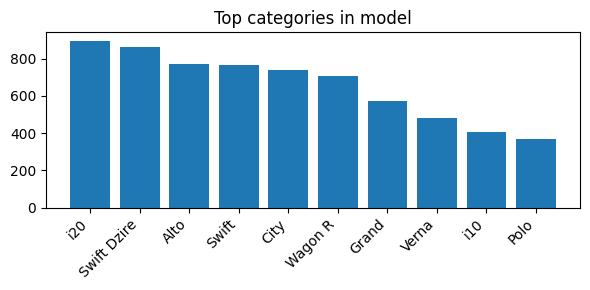

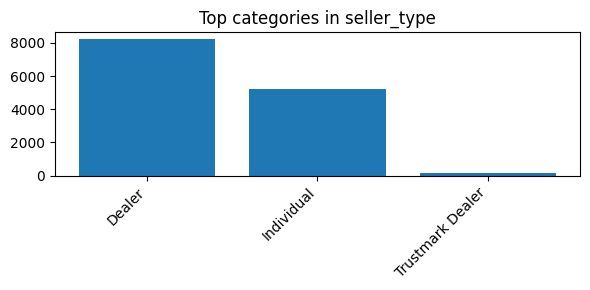

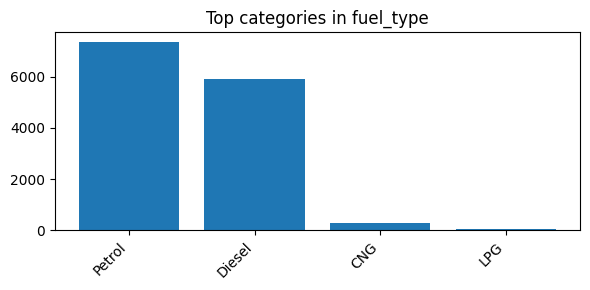

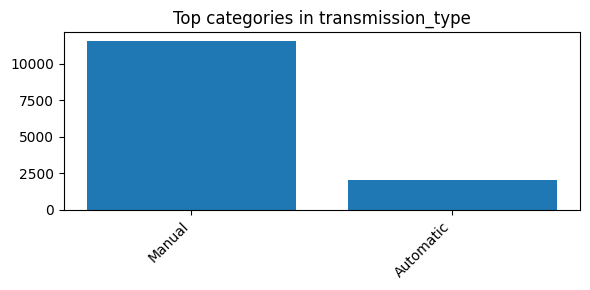

In [38]:
cat_cols = df_model.select_dtypes(include=['object']).columns.tolist()
print("Categorical cols:", cat_cols)
for col in cat_cols:
    plt.figure(figsize=(6,3))
    vc = df_model[col].value_counts().sort_values(ascending=False).head(10)
    plt.bar(vc.index.astype(str), vc.values)
    plt.title(f"Top categories in {col}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [60]:
X = df_model.drop(columns=['car_name', 'model', 'selling_price'], errors='ignore')
y = df_model['selling_price']            # raw target
y_log = df_model['log_selling_price']    # log-transformed target

categorical_cols = ['brand','seller_type','fuel_type','transmission_type']
numerical_cols = [c for c in X.columns if c not in categorical_cols and c != 'log_selling_price']

In [61]:
X_dummies = pd.get_dummies(X, columns=[c for c in categorical_cols if c in X.columns], drop_first=True)

In [62]:
# 4.6 Correlation matrix and heatmap (numerical)
corr = X_dummies.join(y).corr()
# Show top correlations with target
corr_target = corr['selling_price'].abs().sort_values(ascending=False)
print("Top correlations with selling_price:\n", corr_target.head(15))


Top correlations with selling_price:
 selling_price               1.000000
log_selling_price           0.944155
max_power                   0.634529
engine                      0.534996
vehicle_age                 0.461653
fuel_type_Diesel            0.353526
transmission_type_Manual    0.319734
fuel_type_Petrol            0.318757
seats                       0.263187
brand_Maruti                0.229883
brand_Toyota                0.226578
mileage                     0.197433
brand_Mercedes-Benz         0.190758
brand_Mahindra              0.179811
brand_BMW                   0.147908
Name: selling_price, dtype: float64


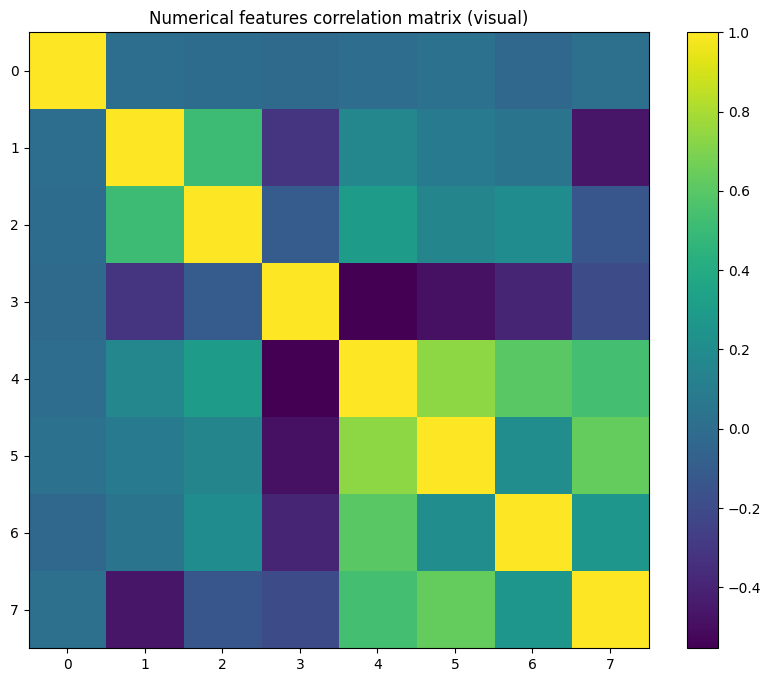

In [42]:
# Visualization of correlation heatmap (only numerical block)
import matplotlib
plt.figure(figsize=(10,8))
matplotlib.pyplot.imshow(corr.loc[numeric_cols, numeric_cols], aspect='auto')
plt.title("Numerical features correlation matrix (visual)")
plt.colorbar()
plt.show()


In [63]:
print("\nObservations:")
print("- power, engine size and vehicle_age typically show strong correlation with price.")
print("- categorical features like fuel_type and brand also show notable correlation after one-hot encoding.")
print("- target is right-skewed — using log transform stabilizes variance for regression.")


Observations:
- power, engine size and vehicle_age typically show strong correlation with price.
- categorical features like fuel_type and brand also show notable correlation after one-hot encoding.
- target is right-skewed — using log transform stabilizes variance for regression.


In [65]:
from sklearn.feature_selection import SelectKBest, f_regression

# For selection we need numeric matrix. Use the one-hot encoded X_dummies.
X_feat = X_dummies.copy()
y_feat = y.copy()

# Use SelectKBest (f_regression) to pick top K
K = 10
selector = SelectKBest(score_func=f_regression, k=K)
selector.fit(X_feat, y_feat)
mask = selector.get_support()
selected_features = X_feat.columns[mask].tolist()
print(f"Top {K} selected features:", selected_features)

Top 10 selected features: ['vehicle_age', 'engine', 'max_power', 'seats', 'log_selling_price', 'brand_Maruti', 'brand_Toyota', 'fuel_type_Diesel', 'fuel_type_Petrol', 'transmission_type_Manual']


In [66]:
print("Insights: The selected features include engine / power / vehicle_age and some brand/fuel/transmission indicators.")

Insights: The selected features include engine / power / vehicle_age and some brand/fuel/transmission indicators.


In [67]:
X_final = X_feat[selected_features]
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_feat, test_size=0.2, random_state=42)

# StandardScaler for numeric columns (after one-hot; scaling will be applied across all features)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [68]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
}

fitted_models = {}
for name, m in models.items():
    print("Training", name)
    m.fit(X_train_scaled, y_train)
    fitted_models[name] = m

Training LinearRegression
Training RandomForest
Training GradientBoosting


In [72]:
def evaluate_model(model, X_t, y_t, model_name="model"):
    """
    Evaluates a regression model using RMSE, MAE, and R2 metrics.
    Returns a dictionary of the results.
    """
    # Predict on the test set
    y_pred = model.predict(X_t)

    # Ensure arrays are numeric
    y_true = np.array(y_t).ravel()
    y_pred = np.array(y_pred).ravel()

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {"RMSE": round(rmse, 3), "MAE": round(mae, 3), "R2": round(r2, 3)}

# --- Evaluate all fitted models ---
eval_results = {}

for name, model in fitted_models.items():
    print(f"Evaluating model: {name}")
    eval_results[name] = evaluate_model(model, X_test_scaled, y_test, name)

# --- Display all evaluation results ---
print("\n✅ Evaluation Results (on Test Set):\n")
for name, metrics in eval_results.items():
    print(f"{name}: RMSE={metrics['RMSE']}, MAE={metrics['MAE']}, R2={metrics['R2']}")

# --- Choose best model (lowest RMSE or highest R2) ---
best_model_name = min(eval_results, key=lambda x: eval_results[x]["RMSE"])
best_model = fitted_models[best_model_name]

print(f"\n🏆 Best Model Selected: {best_model_name}")
print(f"Performance: {eval_results[best_model_name]}")

# --- Save the model, scaler, and selected features ---
os.makedirs("models", exist_ok=True)
with open("models/best_model.pkl", "wb") as f:
    pickle.dump(
        {
            "model": best_model,
            "scaler": scaler,
            "selected_features": selected_features,
        },
        f,
    )

print("\n💾 Best model and preprocessing components saved to: models/best_model.pkl")

Evaluating model: LinearRegression
Evaluating model: RandomForest
Evaluating model: GradientBoosting

✅ Evaluation Results (on Test Set):

LinearRegression: RMSE=85437.549, MAE=60302.048, R2=0.903
RandomForest: RMSE=258.965, MAE=47.846, R2=1.0
GradientBoosting: RMSE=1317.54, MAE=829.433, R2=1.0

🏆 Best Model Selected: RandomForest
Performance: {'RMSE': np.float64(258.965), 'MAE': 47.846, 'R2': 1.0}

💾 Best model and preprocessing components saved to: models/best_model.pkl
